In [1]:
# data analysis & wrangling
import numpy as np # linear algebra
import pandas as pd # data processing
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split, 
    cross_validate, 
    cross_val_score, 
    StratifiedShuffleSplit, 
    GridSearchCV
)

from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_curve,
    roc_auc_score,
    mean_squared_error,
    confusion_matrix,
    ConfusionMatrixDisplay,
    plot_confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
    auc,
    plot_roc_curve, 
    roc_curve
)

from sklearn.preprocessing import (
    LabelEncoder, 
    OneHotEncoder,
    RobustScaler,
    StandardScaler,
    MinMaxScaler,
    OrdinalEncoder,
    FunctionTransformer
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("train.csv")

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 1. Preprocessing

In [4]:
# check the missing values
data.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [5]:
# fill the missing values with mean values according to the 'Pclass' and 'Sex'
data['Age'].fillna(data.groupby(['Sex','Pclass'])['Age'].transform('mean').round(0), inplace=True)

In [6]:
# cut the 'Age' column into 5 equal-sized bins
data['age_cut'] = pd.qcut(data['Age'],5,labels = ['kids', 'young', 'middle_aged', 'old','super_old'])

In [7]:
# count the family members
data['family_size'] = data['SibSp'] + data['Parch'] + 1
#data['family_size'].value_counts(sort=False)

In [8]:
#pd.cut(data["family_size"],bins=[0,1,2,4,6]).value_counts()

In [9]:
data['family_category'] = pd.cut(data['family_size'],bins=[0,1,2,4,6], labels= ['alone','couple','small_family', 'big_family'])
#data["family_category"].value_counts()

In [10]:
data['cabin_number'] = (data['Cabin'].notnull().astype('int'))

In [11]:
southampton = data[data['Embarked'] == "S"].shape[0]
cherbourg = data[data['Embarked'] == "C"].shape[0]
queenstown = data[data['Embarked'] == "Q"].shape[0]

# impute the missing values to the most frequent value
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(data[['Embarked']])        
data['Embarked'] = imputer.transform(data[['Embarked']]);

In [12]:
data['title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
data['title'].value_counts()

# grouping the 'title' into five groups
data['title'] = data['title'].replace(['Lady', 'Capt', 'Col', 'Don', 'Dr', 'Major',
                                       'Rev', 'Jonkheer', 'Dona', 'Countess', 'Sir'], 'Other')
data['title'] = data['title'].replace('Mlle', 'Miss')
data['title'] = data['title'].replace('Ms', 'Miss')
data['title'] = data['title'].replace('Mme', 'Mrs')

# map each of the title groups to a numerical value
#title_dict = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Other": 5}
#data['title'] = data['title'].replace(to_replace=title_dict)

In [13]:
data['Cabin'].fillna('Unknown')
data['cabin_label'] = data.Cabin.apply(lambda x: str(x)[0])

In [14]:
#pd.cut(data['Fare'],bins=[0,8,10,25,50,100]).value_counts()

In [15]:
data['Fare']= data['Fare'].round(2)

data['fare_range'] = pd.cut(data['Fare'],bins=[0,8,10,25,50,100], labels= ['very_cheap', 'cheap', 'middle', 'expensive', 'very_expensive'])
data['fare_range'].value_counts()

very_cheap        226
middle            221
expensive         174
very_expensive    107
cheap              95
Name: fare_range, dtype: int64

Transformations

In [16]:
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_cut,family_size,family_category,cabin_number,title,cabin_label,fare_range
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,young,2,couple,0,Mr,n,very_cheap
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.28,C85,C,old,2,couple,1,Mrs,C,very_expensive


In [ ]:
#data = data.drop(['Name', 'Ticket'], axis=1)

# 2. Division the columns into numeric and categorical columns

In [19]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'age_cut',
       'family_size', 'family_category', 'cabin_number', 'title',
       'cabin_label', 'fare_range'],
      dtype='object')

In [28]:
#bin_cols = ['Sex', 'cabin_number']
#label_encoder = LabelEncoder()
#for column in bin_cols:
    #data[column] = label_encoder.fit_transform(data[column])

#category_cols = ['age_cut', 'family_category',
                 #'title', 'cabin_label', 'fare_range']
#for column in category_cols:
    #data[column] = data[column].astype('category').cat.codes  
    
#cat_transformer = OneHotEncoder(sparse=False).fit_transform(data[cat_cols].values)

In [50]:
cat_cols = ['Pclass', 'Embarked','age_cut', 'family_category',
                 'title', 'cabin_label', 'fare_range', 'Sex', 'cabin_number']

cat_transformer = OneHotEncoder(handle_unknown="ignore")

num_cols = ['Age', 'Fare']
num_transformer = MinMaxScaler()

In [51]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols)
    ]
)

In [52]:
preprocessor

ColumnTransformer(transformers=[('num', MinMaxScaler(), ['Age', 'Fare']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['Pclass', 'Embarked', 'age_cut',
                                  'family_category', 'title', 'cabin_label',
                                  'fare_range', 'Sex', 'cabin_number'])])

# 3. Pipelines

# LogisticRegression

In [87]:
m_lr1 = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier",
                                            LogisticRegression(max_iter=1000))]
)

In [ ]:
#logreg = Pipeline(
    #steps=[("preprocessor", preprocessor), ("classifier",
                                            #LogisticRegression(max_iter=1000, class_weight="balanced"))])
#with class_weight="balanced" train score is 0.84

In [ ]:
data = data.drop(['PassengerId', 'SibSp', 'Parch', 'Name', 'Ticket', 'Cabin', ], axis=1)

In [83]:
X = data.drop('Survived', axis=1)
y = data['Survived']

In [84]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [88]:
m_lr1.fit(X_train, y_train);

In [89]:
m_lr1.score(X_val, y_val)
print(
    f"Logistic Regression Results\nTrain score: {round(logreg.score(X_train, y_train), 2)}\nTest score: {round(logreg.score(X_val, y_val), 2)}")

Logistic Regression Results
Train score: 0.85
Test score: 0.83


In [90]:
ypred = m_lr1.predict(X_val)  # generating predictive results
accuracy_score(y_val, ypred)

0.8295964125560538

In [91]:
# comparing metrics
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'ROC_AUC']
summary = pd.DataFrame(index=metrics)


def summary_metrics(summary, col, y_val, ypred, y_probs):
    values = [accuracy_score(y_val, ypred), precision_score(y_val, ypred), recall_score(y, ypred),
              f1_score(y_val, ypred), roc_auc_score(y_val, y_probs)]
    summary[col] = values
    return summary

print('accuracy: ', accuracy_score(y_val, ypred))
print('precision: ', precision_score(y_val, ypred))
print('recall: ', recall_score(y_val, ypred))
print('f1_score: ', f1_score(y_val, ypred))

accuracy:  0.8295964125560538
precision:  0.8
recall:  0.7640449438202247
f1_score:  0.7816091954022989


In [92]:
conf = confusion_matrix(y_val, ypred)
conf

array([[117,  17],
       [ 21,  68]])

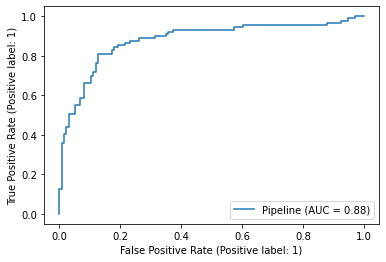

In [93]:
plot_roc_curve(m_lr1, X_val, y_val)

In [94]:
fpr, tpr, threshold = roc_curve(y_val, m_lr1.predict_proba(X_val)[:,1]);

In [95]:
auc_score = auc(fpr, tpr)
print("Area under the curve = ", auc_score)

Area under the curve =  0.8798423612275701


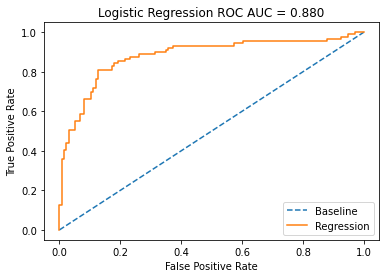

In [96]:
probs = m_lr1.predict_proba(X_val)
probs = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_val, probs)
roc_auc = roc_auc_score(y_val, probs)

# visualisation ROC AUC
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

# RandomForest

In [97]:
m_rf1 = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier(n_estimators=15, max_depth=5))]
)

In [98]:
m_rf1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Pclass', 'Embarked',
                                                   'age_cut', 'family_category',
                                                   'title', 'cabin_label',
                                                   'fare_range', 'Sex',
                                                   'cabin_number'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=5, n_estimators=15))])

In [99]:
ypred = m_rf1.predict(X_val)

In [100]:
print(f"Random Forest Results\nTest score: {round(accuracy_score(ypred,y_val), 2)}")

Random Forest Results
Test score: 0.81


In [101]:
print('accuracy: ', accuracy_score(y_val, ypred))
print('precision: ', precision_score(y_val, ypred))
print('recall: ', recall_score(y_val, ypred))
print('f1_score: ', f1_score(y_val, ypred))

accuracy:  0.8071748878923767
precision:  0.7674418604651163
recall:  0.7415730337078652
f1_score:  0.7542857142857143


In [102]:
conf = confusion_matrix(y_val, ypred)
conf

array([[114,  20],
       [ 23,  66]])

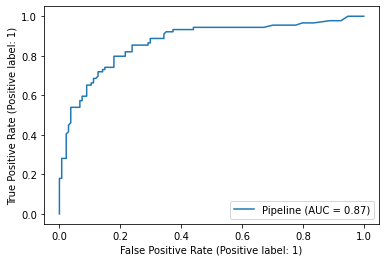

In [103]:
plot_roc_curve(m_rf1, X_val, y_val)

In [104]:
fpr, tpr, threshold = roc_curve(y_val, m_rf1.predict_proba(X_val)[:,1]);

In [105]:
auc_score = auc(fpr, tpr)
print("Area under the curve = ", auc_score)

Area under the curve =  0.8707026664430657


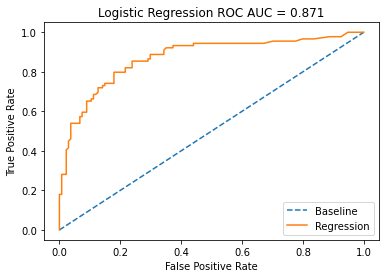

In [106]:
probs = m_rf1.predict_proba(X_val)
probs = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_val, probs)
roc_auc = roc_auc_score(y_val, probs)

# visualisation ROC AUC
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [107]:
acc_rf = cross_val_score(m_rf1, X_train, y_train, \
                      cv=10, scoring='accuracy')
acc_rf

array([0.88059701, 0.71641791, 0.85074627, 0.89552239, 0.8358209 ,
       0.73134328, 0.82089552, 0.76119403, 0.75757576, 0.92424242])

In [108]:
results = cross_val_score(m_rf1, X_train, y_train,cv=10) 
results.mean()

0.8264360018091361

In [109]:
results.std()

0.05941360233202771